# LSTM

In [1]:
#import packages
import numpy as np
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import random
import math
from datetime import datetime
import pickle
import pandas as pd
%matplotlib inline

#predefined activation function and its derivative
def Sigmoid(x): 
    return 1. / (1 + np.exp(-x))

def dSigmoid(values): 
    return values*(1-values)

def Tanh(x):
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def dtanh(values): 
    return 1. - values**2

def rand_arr(a, b, *args): 
    seed(0)
    return rand(*args)*(b - a) + a

#LSTM Class
class LSTM:
    def __init__(self, X_dim, y_dim, neuron):
        
        self.X_dim = X_dim 
        self.y_dim = y_dim
        self.neuron = neuron
        
        #initiate weight
        self.weight_f = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_i = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_g = rand_arr(-0.1, 0.1, neuron, X_dim + neuron) 
        self.weight_o = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_out = rand_arr(-0.1, 0.1, y_dim, neuron)
        
        #initiate bias
        self.bias_f = rand_arr(-0.1, 0.1, neuron) 
        self.bias_i = rand_arr(-0.1, 0.1, neuron) 
        self.bias_g = rand_arr(-0.1, 0.1, neuron) 
        self.bias_o = rand_arr(-0.1, 0.1, neuron)
        self.bias_out = rand_arr(-0.1, 0.1, y_dim)
    
    def forward(self, inputs, outputs):
        X = inputs
        y = outputs
        
        self.X = X
        self.y = y
        #make list to save the values of every unit 
        self.X_concat = []
        self.f = []
        self.i = []
        self.g = []
        self.o = []
        self.s = [zeros(self.neuron)] #first s input is 0
        self.h = [zeros(self.neuron)] #first h input is 0
        self.out = []
        self.error = []
        for i in range(len(inputs)):
            #forward for every unit
            X_concat = np.hstack((X[i],  self.h[i]))
            self.X_concat.append(X_concat)
            self.f.append(Sigmoid(self.weight_f@X_concat + self.bias_f))
            self.i.append(Sigmoid(self.weight_i@X_concat + self.bias_i))
            self.g.append(Tanh(self.weight_g@X_concat + self.bias_g))
            self.o.append(Sigmoid(self.weight_o@X_concat + self.bias_o))
            self.s.append(self.f[i]*self.s[i] + self.i[i]*self.g[i])
            self.h.append(Tanh(self.s[i+1])*self.o[i])
            self.out.append(self.weight_out@self.h[i+1] + self.bias_out)
            self.error.append(abs(self.out[-1] - y[i]))
        #show error
        #print(np.array(self.error).mean())
    
    def backward(self, inputs, outputs):
        self.diff_out = []
        self.diff_h = []
        self.diff_h_bottom = [zeros(self.neuron)]
        self.diff_s_up = [zeros(self.neuron)]
        self.diff_s = []
        self.diff_o = []
        self.diff_g = []
        self.diff_i = []
        self.diff_f = []
        for i in range(len(inputs)-1,-1,-1):
            #derivate of output
            if i == len(inputs)-1:
                self.diff_out  = [2*(self.out[i] - outputs[i])] + self.diff_out
                self.diff_h = [self.diff_out[0]*dSigmoid(self.weight_out@self.h[i+1] + self.bias_out)*self.weight_out + self.diff_h_bottom[0]] + self.diff_h
            else:
                self.diff_h = [self.diff_h_bottom[0]] + self.diff_h
            
            
            #derivative of gate/neural network operation
            self.diff_s = [self.diff_h[0]*self.o[i]*dtanh(self.s[i+1]) + self.diff_s_up[0]] + self.diff_s
            self.diff_o = [self.diff_h[0]*Tanh(self.s[i+1])] + self.diff_o
            self.diff_g = [self.i[i]*self.diff_s[0]] + self.diff_g
            self.diff_i = [self.g[i]*self.diff_s[0]] + self.diff_i
            self.diff_f = [self.s[i]*self.diff_s[0]] + self.diff_f
            
            #derivative of concatenation of input dan previous output value
            self.dX_concat = (self.diff_o[0].T*(dSigmoid(self.o[i]).reshape(self.neuron,1))).T@self.weight_o
            self.dX_concat += (self.diff_g[0].T*(dSigmoid(self.g[i]).reshape(self.neuron,1))).T@self.weight_g
            self.dX_concat += (self.diff_i[0].T*(dSigmoid(self.i[i]).reshape(self.neuron,1))).T@self.weight_i
            self.dX_concat += (self.diff_f[0].T*(dSigmoid(self.f[i]).reshape(self.neuron,1))).T@self.weight_f
            
            #update value of long and short term memory
            self.diff_h_bottom = [self.dX_concat[-1][self.X_dim:]] + self.diff_h_bottom
            self.diff_s_up = [self.diff_s[0]*self.f[i]] + self.diff_s_up
            
    def update(self, alpha):
        
        #alpha 
        
        #update everyweight and bias
        self.weight_out -= alpha*self.diff_out[0].reshape(1,1)@self.h[1].T.reshape(1,self.neuron)
        self.bias_out -= alpha*self.diff_out[0]
        
        self.weight_f -= alpha*(self.diff_f[0]*dSigmoid(self.weight_f@self.X_concat[0] + self.bias_f)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_f -= alpha*(self.diff_f[0]*dSigmoid(self.weight_f@self.X_concat[0] + self.bias_f)).reshape(self.neuron,)
        
        self.weight_i -= alpha*(self.diff_i[0]*dSigmoid(self.weight_i@self.X_concat[0] + self.bias_i)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_i -= alpha*(self.diff_i[0]*dSigmoid(self.weight_i@self.X_concat[0] + self.bias_i)).reshape(self.neuron,)
        
        self.weight_g -= alpha*(self.diff_g[0]*dSigmoid(self.weight_g@self.X_concat[0] + self.bias_g)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_g -= alpha*(self.diff_g[0]*dSigmoid(self.weight_g@self.X_concat[0] + self.bias_g)).reshape(self.neuron,)
        
        self.weight_o -= alpha*(self.diff_o[0]*dSigmoid(self.weight_o@self.X_concat[0] + self.bias_o)).T.reshape(self.neuron,1)@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_o -= alpha*(self.diff_o[0]*dSigmoid(self.weight_o@self.X_concat[0] + self.bias_o)).reshape(self.neuron,)
    
    def predict(self, inputs, outputs):
        X = inputs
        y = outputs
        self.X = X
        self.y = y
        #make list to save the values of every unit 
        self.X_concat = []
        self.f = []
        self.i = []
        self.g = []
        self.o = []
        self.s = [zeros(self.neuron)] #first s input is 0
        self.h = [zeros(self.neuron)] #first h input is 0
        self.out = []
        self.error = []
        for i in range(len(inputs)):
            #forward for every unit
            X_concat = np.hstack((X[i],  self.h[i]))
            self.X_concat.append(X_concat)
            self.f.append(Sigmoid(self.weight_f@X_concat + self.bias_f))
            self.i.append(Sigmoid(self.weight_i@X_concat + self.bias_i))
            self.g.append(Tanh(self.weight_g@X_concat + self.bias_g))
            self.o.append(Sigmoid(self.weight_o@X_concat + self.bias_o))
            self.s.append(self.f[i]*self.s[i] + self.i[i]*self.g[i])
            self.h.append(Tanh(self.s[i+1])*self.o[i])
            self.out.append(self.weight_out@self.h[i+1] + self.bias_out)
            self.error.append(abs(self.out[-1] - y[i]))
        
        return [self.out[-1][0],self.y[-1]]
    
    def show_progress(self):
        return abs(self.y[-1][0] - self.out[-1])

# Import Dataset

In [3]:
df = pd.read_csv('Datasets/FISH-short.csv')
df.drop('Volume', inplace=True, axis=1)
df

,Date,Open,High,Low,Close,Adj Close
0,2017-01-02,4000.0,4000.0,4000.0,4000.0,3481.112061
1,2017-01-03,3900.0,5000.0,3900.0,4800.0,4177.334473
2,2017-01-04,4800.0,4800.0,4800.0,4800.0,4177.334473
3,2017-01-05,4800.0,4800.0,4800.0,4800.0,4177.334473
4,2017-01-06,4800.0,4800.0,4800.0,4800.0,4177.334473
...,...,...,...,...,...,...
58,2017-03-23,3400.0,3450.0,3400.0,3450.0,3002.458984
59,2017-03-24,3450.0,3450.0,3350.0,3350.0,2915.430908
60,2017-03-27,2650.0,2700.0,2650.0,2650.0,2306.236572
61,2017-03-29,2700.0,3100.0,2700.0,3100.0,2697.861816


In [20]:
df_open = df.reset_index()['Open']
df_open

0     4000.0
1     3900.0
2     4800.0
3     4800.0
4     4800.0
       ...  
58    3400.0
59    3450.0
60    2650.0
61    2700.0
62    3100.0
Name: Open, Length: 63, dtype: float64

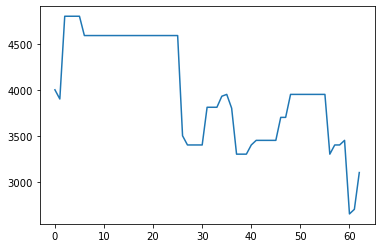

In [22]:
plt.plot(df_open)

# MinMax Scaler

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df_open = scaler.fit_transform(np.array(df_open).reshape(-1,1))
df_open

array([[0.62790698],
       [0.58139535],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.90232558],
       [0.90232558],
       [0.90232558],
       [0.90232558],
       [0.90232558],
       [0.90232558],
       [0.90232558],
       [0.90232558],
       [0.90232558],
       [0.90232558],
       [0.90232558],
       [0.90232558],
       [0.90232558],
       [0.90232558],
       [0.90232558],
       [0.90232558],
       [0.90232558],
       [0.90232558],
       [0.90232558],
       [0.90232558],
       [0.39534884],
       [0.34883721],
       [0.34883721],
       [0.34883721],
       [0.34883721],
       [0.53953488],
       [0.53953488],
       [0.53953488],
       [0.59534884],
       [0.60465116],
       [0.53488372],
       [0.30232558],
       [0.30232558],
       [0.30232558],
       [0.34883721],
       [0.37209302],
       [0.37209302],
       [0.37209302],
       [0.37209302],
       [0.37209302],
       [0.48837209],
       [0.488

# Splitting Training and Testing

In [24]:
training_size = int(len(df_open)*0.8)
test_size = len(df_open)-training_size
train_data, test_data = df_open[0:training_size,:], df_open[training_size:len(df_open),:1]

In [30]:
training_size, test_size

(50, 13)

In [33]:
xs = train_data

In [38]:
#Standarized the dataset
N       = xs.shape[0]

#hypreparameter
nc      = 4  
Ts      = 5
x_dim   = 10
alpha   = 0.01
epochs  = 50000

xt      = xs[0:N-x_dim,:]

for i in range(x_dim):
    xt  = hstack((xt, xs[i+1:N-x_dim+i+1]))   

X_train = xt[:-30, 0:x_dim]     
y_train = xt[:-30, x_dim:x_dim+1]  
X_test = xt[-30:, 0:x_dim]     
y_test = xt[-30:, x_dim:x_dim+1]  

In [39]:
me = LSTM(x_dim,1,nc)
for i in range(5000):
    print('-------------',i+1,'-------------')
    for j in range(X_train.shape[0]-Ts):
        me.forward(X_train[j:j+Ts],y_train[j:j+Ts])
        me.backward(X_train[j:j+Ts],y_train[j:j+Ts])
        me.update(alpha)
    hehe = []
    for j in range(X_test.shape[0]-Ts):
        me.forward(X_test[j:j+Ts],y_test[j:j+Ts])
        me.backward(X_test[j:j+Ts],y_test[j:j+Ts])
        hehe.append(me.show_progress())    
    print(np.array(hehe).mean())

------------- 1 -------------
0.36736779706180767
------------- 2 -------------
0.2897218336742123
------------- 3 -------------
0.21964648868701311
------------- 4 -------------
0.15845606015933456
------------- 5 -------------
0.12288864619901967
------------- 6 -------------
0.12417708798625889
------------- 7 -------------
0.12978775448112148
------------- 8 -------------
0.1374445319655745
------------- 9 -------------
0.14917291342968475
------------- 10 -------------
0.1696616449762856
------------- 11 -------------
0.1894176626547229
------------- 12 -------------
0.2127692410777955
------------- 13 -------------
0.2338438276153274
------------- 14 -------------
0.25286343928949767
------------- 15 -------------
0.27002844808816573
------------- 16 -------------
0.2855196906550815
------------- 17 -------------
0.2995003724289842
------------- 18 -------------
0.31211778626291886
------------- 19 -------------
0.32350486359437824
------------- 20 -------------
0.333781574472494

0.42894831322606863
------------- 180 -------------
0.4289483091794424
------------- 181 -------------
0.42894830504410303
------------- 182 -------------
0.42894830082869917
------------- 183 -------------
0.42894829654103633
------------- 184 -------------
0.42894829218815894
------------- 185 -------------
0.4289482877764246
------------- 186 -------------
0.42894828331157064
------------- 187 -------------
0.4289482787987752
------------- 188 -------------
0.42894827424271154
------------- 189 -------------
0.42894826964759697
------------- 190 -------------
0.42894826501723776
------------- 191 -------------
0.42894826035506933
------------- 192 -------------
0.4289482556641915
------------- 193 -------------
0.4289482509474021
------------- 194 -------------
0.4289482462072262
------------- 195 -------------
0.42894824144594274
------------- 196 -------------
0.42894823666560805
------------- 197 -------------
0.42894823186807857
------------- 198 -------------
0.4289482270550289

0.42894748471415783
------------- 349 -------------
0.4289474797551101
------------- 350 -------------
0.4289474747960458
------------- 351 -------------
0.428947469836965
------------- 352 -------------
0.4289474648778674
------------- 353 -------------
0.4289474599187534
------------- 354 -------------
0.42894745495962266
------------- 355 -------------
0.4289474500004753
------------- 356 -------------
0.4289474450413115
------------- 357 -------------
0.4289474400821308
------------- 358 -------------
0.4289474351229336
------------- 359 -------------
0.42894743016371967
------------- 360 -------------
0.42894742520448914
------------- 361 -------------
0.42894742024524213
------------- 362 -------------
0.42894741528597835
------------- 363 -------------
0.4289474103266981
------------- 364 -------------
0.4289474053674011
------------- 365 -------------
0.42894740040808765
------------- 366 -------------
0.42894739544875743
------------- 367 -------------
0.4289473904894104
-----

0.42894669105503636
------------- 509 -------------
0.42894668609332803
------------- 510 -------------
0.42894668113160317
------------- 511 -------------
0.42894667616986143
------------- 512 -------------
0.42894667120810337
------------- 513 -------------
0.4289466662463286
------------- 514 -------------
0.42894666128453723
------------- 515 -------------
0.42894665632272916
------------- 516 -------------
0.4289466513609046
------------- 517 -------------
0.4289466463990632
------------- 518 -------------
0.42894664143720523
------------- 519 -------------
0.42894663647533066
------------- 520 -------------
0.42894663151343937
------------- 521 -------------
0.4289466265515313
------------- 522 -------------
0.4289466215896068
------------- 523 -------------
0.4289466166276656
------------- 524 -------------
0.42894661166570786
------------- 525 -------------
0.42894660670373347
------------- 526 -------------
0.4289466017417423
------------- 527 -------------
0.42894659677973457

0.42894587711250104
------------- 673 -------------
0.42894587214806384
------------- 674 -------------
0.4289458671836103
------------- 675 -------------
0.42894586221913983
------------- 676 -------------
0.42894585725465284
------------- 677 -------------
0.42894585229014914
------------- 678 -------------
0.4289458473256287
------------- 679 -------------
0.42894584236109196
------------- 680 -------------
0.4289458373965384
------------- 681 -------------
0.42894583243196815
------------- 682 -------------
0.42894582746738125
------------- 683 -------------
0.42894582250277774
------------- 684 -------------
0.4289458175381576
------------- 685 -------------
0.4289458125735208
------------- 686 -------------
0.4289458076088672
------------- 687 -------------
0.42894580264419707
------------- 688 -------------
0.42894579767951035
------------- 689 -------------
0.42894579271480704
------------- 690 -------------
0.4289457877500869
------------- 691 -------------
0.4289457827853502


0.4289450676894618
------------- 836 -------------
0.42894506272231114
------------- 837 -------------
0.42894505775514363
------------- 838 -------------
0.4289450527879594
------------- 839 -------------
0.42894504782075876
------------- 840 -------------
0.42894504285354124
------------- 841 -------------
0.42894503788630706
------------- 842 -------------
0.4289450329190563
------------- 843 -------------
0.42894502795178885
------------- 844 -------------
0.4289450229845049
------------- 845 -------------
0.42894501801720414
------------- 846 -------------
0.4289450130498868
------------- 847 -------------
0.42894500808255276
------------- 848 -------------
0.42894500311520195
------------- 849 -------------
0.42894499814783443
------------- 850 -------------
0.42894499318045043
------------- 851 -------------
0.4289449882130497
------------- 852 -------------
0.42894498324563235
------------- 853 -------------
0.42894497827819833
------------- 854 -------------
0.4289449733107476

0.4289442677636335
------------- 997 -------------
0.4289442627938008
------------- 998 -------------
0.42894425782395124
------------- 999 -------------
0.428944252854085
------------- 1000 -------------
0.42894424788420205
------------- 1001 -------------
0.42894424291430255
------------- 1002 -------------
0.42894423794438624
------------- 1003 -------------
0.42894423297445333
------------- 1004 -------------
0.42894422800450377
------------- 1005 -------------
0.4289442230345376
------------- 1006 -------------
0.42894421806455485
------------- 1007 -------------
0.4289442130945552
------------- 1008 -------------
0.42894420812453915
------------- 1009 -------------
0.42894420315450643
------------- 1010 -------------
0.42894419818445684
------------- 1011 -------------
0.42894419321439076
------------- 1012 -------------
0.42894418824430786
------------- 1013 -------------
0.42894418327420847
------------- 1014 -------------
0.42894417830409215
------------- 1015 -------------
0.

0.42894345248827503
------------- 1161 -------------
0.4289434475157088
------------- 1162 -------------
0.42894344254312544
------------- 1163 -------------
0.42894343757052555
------------- 1164 -------------
0.42894343259790907
------------- 1165 -------------
0.428943427625276
------------- 1166 -------------
0.4289434226526261
------------- 1167 -------------
0.4289434176799597
------------- 1168 -------------
0.4289434127072764
------------- 1169 -------------
0.42894340773457657
------------- 1170 -------------
0.42894340276186016
------------- 1171 -------------
0.4289433977891269
------------- 1172 -------------
0.4289433928163771
------------- 1173 -------------
0.42894338784361047
------------- 1174 -------------
0.4289433828708272
------------- 1175 -------------
0.42894337789802733
------------- 1176 -------------
0.42894337292521073
------------- 1177 -------------
0.4289433679523774
------------- 1178 -------------
0.42894336297952745
------------- 1179 -------------
0.4

0.4289426268138544
------------- 1327 -------------
0.4289426218385193
------------- 1328 -------------
0.4289426168631676
------------- 1329 -------------
0.4289426118877991
------------- 1330 -------------
0.4289426069124139
------------- 1331 -------------
0.4289426019370123
------------- 1332 -------------
0.42894259696159365
------------- 1333 -------------
0.4289425919861584
------------- 1334 -------------
0.42894258701070653
------------- 1335 -------------
0.4289425820352381
------------- 1336 -------------
0.42894257705975286
------------- 1337 -------------
0.4289425720842509
------------- 1338 -------------
0.4289425671087323
------------- 1339 -------------
0.428942562133197
------------- 1340 -------------
0.42894255715764507
------------- 1341 -------------
0.42894255218207644
------------- 1342 -------------
0.42894254720649116
------------- 1343 -------------
0.42894254223088907
------------- 1344 -------------
0.42894253725527043
------------- 1345 -------------
0.428

0.42894184548190806
------------- 1484 -------------
0.42894184050395295
------------- 1485 -------------
0.42894183552598114
------------- 1486 -------------
0.42894183054799273
------------- 1487 -------------
0.42894182556998767
------------- 1488 -------------
0.4289418205919657
------------- 1489 -------------
0.4289418156139273
------------- 1490 -------------
0.4289418106358719
------------- 1491 -------------
0.42894180565780005
------------- 1492 -------------
0.42894180067971155
------------- 1493 -------------
0.4289417957016061
------------- 1494 -------------
0.4289417907234842
------------- 1495 -------------
0.42894178574534536
------------- 1496 -------------
0.42894178076719014
------------- 1497 -------------
0.4289417757890178
------------- 1498 -------------
0.4289417708108292
------------- 1499 -------------
0.4289417658326238
------------- 1500 -------------
0.42894176085440155
------------- 1501 -------------
0.4289417558761628
------------- 1502 -------------
0.

0.4289409989897077
------------- 1654 -------------
0.42894099400891406
------------- 1655 -------------
0.4289409890281037
------------- 1656 -------------
0.4289409840472766
------------- 1657 -------------
0.42894097906643275
------------- 1658 -------------
0.4289409740855723
------------- 1659 -------------
0.4289409691046951
------------- 1660 -------------
0.4289409641238012
------------- 1661 -------------
0.42894095914289065
------------- 1662 -------------
0.4289409541619632
------------- 1663 -------------
0.4289409491810192
------------- 1664 -------------
0.4289409442000585
------------- 1665 -------------
0.4289409392190811
------------- 1666 -------------
0.42894093423808693
------------- 1667 -------------
0.4289409292570761
------------- 1668 -------------
0.4289409242760485
------------- 1669 -------------
0.4289409192950045
------------- 1670 -------------
0.4289409143139435
------------- 1671 -------------
0.4289409093328656
------------- 1672 -------------
0.428940

0.4289401719491639
------------- 1820 -------------
0.4289401669655967
------------- 1821 -------------
0.4289401619820129
------------- 1822 -------------
0.4289401569984123
------------- 1823 -------------
0.4289401520147949
------------- 1824 -------------
0.4289401470311608
------------- 1825 -------------
0.4289401420475101
------------- 1826 -------------
0.42894013706384265
------------- 1827 -------------
0.4289401320801584
------------- 1828 -------------
0.4289401270964575
------------- 1829 -------------
0.42894012211273996
------------- 1830 -------------
0.4289401171290056
------------- 1831 -------------
0.4289401121452545
------------- 1832 -------------
0.42894010716148673
------------- 1833 -------------
0.4289401021777022
------------- 1834 -------------
0.42894009719390114
------------- 1835 -------------
0.42894009221008317
------------- 1836 -------------
0.4289400872262484
------------- 1837 -------------
0.4289400822423971
------------- 1838 -------------
0.42894

0.428939294583905
------------- 1996 -------------
0.4289392895973954
------------- 1997 -------------
0.42893928461086905
------------- 1998 -------------
0.42893927962432615
------------- 1999 -------------
0.42893927463776643
------------- 2000 -------------
0.4289392696511898
------------- 2001 -------------
0.4289392646645966
------------- 2002 -------------
0.42893925967798663
------------- 2003 -------------
0.42893925469135996
------------- 2004 -------------
0.42893924970471664
------------- 2005 -------------
0.4289392447180566
------------- 2006 -------------
0.4289392397313798
------------- 2007 -------------
0.4289392347446861
------------- 2008 -------------
0.42893922975797594
------------- 2009 -------------
0.42893922477124896
------------- 2010 -------------
0.42893921978450517
------------- 2011 -------------
0.4289392147977447
------------- 2012 -------------
0.42893920981096756
------------- 2013 -------------
0.42893920482417364
------------- 2014 -------------
0.

0.42893846160495175
------------- 2163 -------------
0.42893845661564856
------------- 2164 -------------
0.42893845162632843
------------- 2165 -------------
0.4289384466369917
------------- 2166 -------------
0.4289384416476382
------------- 2167 -------------
0.42893843665826814
------------- 2168 -------------
0.42893843166888135
------------- 2169 -------------
0.42893842667947757
------------- 2170 -------------
0.42893842169005725
------------- 2171 -------------
0.4289384167006202
------------- 2172 -------------
0.4289384117111663
------------- 2173 -------------
0.42893840672169575
------------- 2174 -------------
0.42893840173220854
------------- 2175 -------------
0.4289383967427045
------------- 2176 -------------
0.4289383917531836
------------- 2177 -------------
0.42893838676364615
------------- 2178 -------------
0.4289383817740919
------------- 2179 -------------
0.428938376784521
------------- 2180 -------------
0.4289383717949334
------------- 2181 -------------
0.4

0.42893763315139977
------------- 2329 -------------
0.428937628159318
------------- 2330 -------------
0.42893762316721945
------------- 2331 -------------
0.42893761817510423
------------- 2332 -------------
0.4289376131829721
------------- 2333 -------------
0.4289376081908234
------------- 2334 -------------
0.42893760319865776
------------- 2335 -------------
0.4289375982064753
------------- 2336 -------------
0.4289375932142762
------------- 2337 -------------
0.4289375882220604
------------- 2338 -------------
0.4289375832298279
------------- 2339 -------------
0.42893757823757866
------------- 2340 -------------
0.42893757324531256
------------- 2341 -------------
0.4289375682530297
------------- 2342 -------------
0.4289375632607303
------------- 2343 -------------
0.428937558268414
------------- 2344 -------------
0.4289375532760811
------------- 2345 -------------
0.42893754828373126
------------- 2346 -------------
0.4289375432913649
------------- 2347 -------------
0.42893

0.42893682921052195
------------- 2490 -------------
0.42893682421574353
------------- 2491 -------------
0.4289368192209484
------------- 2492 -------------
0.42893681422613683
------------- 2493 -------------
0.42893680923130817
------------- 2494 -------------
0.4289368042364627
------------- 2495 -------------
0.4289367992416006
------------- 2496 -------------
0.42893679424672176
------------- 2497 -------------
0.4289367892518262
------------- 2498 -------------
0.428936784256914
------------- 2499 -------------
0.42893677926198476
------------- 2500 -------------
0.4289367742670388
------------- 2501 -------------
0.42893676927207613
------------- 2502 -------------
0.4289367642770967
------------- 2503 -------------
0.42893675928210057
------------- 2504 -------------
0.4289367542870876
------------- 2505 -------------
0.42893674929205794
------------- 2506 -------------
0.42893674429701156
------------- 2507 -------------
0.4289367393019484
------------- 2508 -------------
0.4

0.4289360198379073
------------- 2652 -------------
0.4289360148404141
------------- 2653 -------------
0.42893600984290414
------------- 2654 -------------
0.42893600484537747
------------- 2655 -------------
0.428935999847834
------------- 2656 -------------
0.4289359948502737
------------- 2657 -------------
0.42893598985269676
------------- 2658 -------------
0.42893598485510326
------------- 2659 -------------
0.4289359798574926
------------- 2660 -------------
0.4289359748598652
------------- 2661 -------------
0.42893596986222116
------------- 2662 -------------
0.4289359648645603
------------- 2663 -------------
0.42893595986688277
------------- 2664 -------------
0.4289359548691883
------------- 2665 -------------
0.42893594987147715
------------- 2666 -------------
0.42893594487374925
------------- 2667 -------------
0.4289359398760046
------------- 2668 -------------
0.4289359348782431
------------- 2669 -------------
0.428935929880465
------------- 2670 -------------
0.4289

0.42893513502045805
------------- 2829 -------------
0.428935130019997
------------- 2830 -------------
0.4289351250195192
------------- 2831 -------------
0.4289351200190245
------------- 2832 -------------
0.42893511501851295
------------- 2833 -------------
0.42893511001798473
------------- 2834 -------------
0.42893510501743953
------------- 2835 -------------
0.4289351000168777
------------- 2836 -------------
0.428935095016299
------------- 2837 -------------
0.4289350900157036
------------- 2838 -------------
0.42893508501509153
------------- 2839 -------------
0.4289350800144626
------------- 2840 -------------
0.4289350750138169
------------- 2841 -------------
0.4289350700131544
------------- 2842 -------------
0.4289350650124753
------------- 2843 -------------
0.42893506001177917
------------- 2844 -------------
0.4289350550110663
------------- 2845 -------------
0.4289350500103367
------------- 2846 -------------
0.4289350450095904
------------- 2847 -------------
0.428935

0.4289343147205813
------------- 2993 -------------
0.4289343097173684
------------- 2994 -------------
0.42893430471413885
------------- 2995 -------------
0.42893429971089225
------------- 2996 -------------
0.42893429470762906
------------- 2997 -------------
0.42893428970434916
------------- 2998 -------------
0.4289342847010523
------------- 2999 -------------
0.4289342796977387
------------- 3000 -------------
0.4289342746944083
------------- 3001 -------------
0.42893426969106124
------------- 3002 -------------
0.4289342646876972
------------- 3003 -------------
0.42893425968431637
------------- 3004 -------------
0.4289342546809188
------------- 3005 -------------
0.42893424967750454
------------- 3006 -------------
0.4289342446740736
------------- 3007 -------------
0.4289342396706259
------------- 3008 -------------
0.42893423466716113
------------- 3009 -------------
0.42893422966367956
------------- 3010 -------------
0.4289342246601814
------------- 3011 -------------
0.4

0.4289335240047364
------------- 3151 -------------
0.42893351899887094
------------- 3152 -------------
0.42893351399298857
------------- 3153 -------------
0.42893350898708954
------------- 3154 -------------
0.42893350398117364
------------- 3155 -------------
0.42893349897524097
------------- 3156 -------------
0.4289334939692916
------------- 3157 -------------
0.42893348896332534
------------- 3158 -------------
0.4289334839573422
------------- 3159 -------------
0.42893347895134254
------------- 3160 -------------
0.4289334739453258
------------- 3161 -------------
0.42893346893929246
------------- 3162 -------------
0.4289334639332423
------------- 3163 -------------
0.4289334589271752
------------- 3164 -------------
0.42893345392109156
------------- 3165 -------------
0.42893344891499113
------------- 3166 -------------
0.42893344390887367
------------- 3167 -------------
0.4289334389027394
------------- 3168 -------------
0.4289334338965884
------------- 3169 -------------
0

0.4289326627488627
------------- 3323 -------------
0.428932657740108
------------- 3324 -------------
0.42893265273133624
------------- 3325 -------------
0.4289326477225478
------------- 3326 -------------
0.42893264271374254
------------- 3327 -------------
0.42893263770492057
------------- 3328 -------------
0.42893263269608184
------------- 3329 -------------
0.42893262768722606
------------- 3330 -------------
0.42893262267835364
------------- 3331 -------------
0.4289326176694644
------------- 3332 -------------
0.4289326126605583
------------- 3333 -------------
0.4289326076516356
------------- 3334 -------------
0.428932602642696
------------- 3335 -------------
0.4289325976337395
------------- 3336 -------------
0.4289325926247662
------------- 3337 -------------
0.42893258761577613
------------- 3338 -------------
0.42893258260676925
------------- 3339 -------------
0.4289325775977456
------------- 3340 -------------
0.42893257258870526
------------- 3341 -------------
0.428

0.4289318060074998
------------- 3494 -------------
0.42893180099587064
------------- 3495 -------------
0.42893179598422493
------------- 3496 -------------
0.4289317909725622
------------- 3497 -------------
0.4289317859608826
------------- 3498 -------------
0.42893178094918616
------------- 3499 -------------
0.4289317759374731
------------- 3500 -------------
0.42893177092574303
------------- 3501 -------------
0.428931765913996
------------- 3502 -------------
0.4289317609022323
------------- 3503 -------------
0.428931755890452
------------- 3504 -------------
0.4289317508786547
------------- 3505 -------------
0.4289317458668407
------------- 3506 -------------
0.4289317408550097
------------- 3507 -------------
0.428931735843162
------------- 3508 -------------
0.4289317308312976
------------- 3509 -------------
0.42893172581941613
------------- 3510 -------------
0.428931720807518
------------- 3511 -------------
0.428931715795603
------------- 3512 -------------
0.4289317107

0.42893099390426875
------------- 3656 -------------
0.42893098888991504
------------- 3657 -------------
0.4289309838755446
------------- 3658 -------------
0.42893097886115716
------------- 3659 -------------
0.42893097384675277
------------- 3660 -------------
0.4289309688323317
------------- 3661 -------------
0.4289309638178939
------------- 3662 -------------
0.42893095880343923
------------- 3663 -------------
0.4289309537889675
------------- 3664 -------------
0.42893094877447907
------------- 3665 -------------
0.428930943759974
------------- 3666 -------------
0.428930938745452
------------- 3667 -------------
0.4289309337309131
------------- 3668 -------------
0.42893092871635735
------------- 3669 -------------
0.4289309237017847
------------- 3670 -------------
0.4289309186871956
------------- 3671 -------------
0.42893091367258934
------------- 3672 -------------
0.4289309086579665
------------- 3673 -------------
0.4289309036433266
------------- 3674 -------------
0.4289

0.42893018135951366
------------- 3818 -------------
0.42893017634243363
------------- 3819 -------------
0.42893017132533673
------------- 3820 -------------
0.428930166308223
------------- 3821 -------------
0.4289301612910924
------------- 3822 -------------
0.4289301562739452
------------- 3823 -------------
0.428930151256781
------------- 3824 -------------
0.4289301462396001
------------- 3825 -------------
0.4289301412224022
------------- 3826 -------------
0.42893013620518744
------------- 3827 -------------
0.42893013118795587
------------- 3828 -------------
0.4289301261707073
------------- 3829 -------------
0.42893012115344203
------------- 3830 -------------
0.42893011613616006
------------- 3831 -------------
0.4289301111188611
------------- 3832 -------------
0.4289301061015455
------------- 3833 -------------
0.4289301010842129
------------- 3834 -------------
0.4289300960668635
------------- 3835 -------------
0.4289300910494974
------------- 3836 -------------
0.42893

0.4289293131541635
------------- 3991 -------------
0.4289293081341703
------------- 3992 -------------
0.4289293031141602
------------- 3993 -------------
0.4289292980941333
------------- 3994 -------------
0.42892929307408956
------------- 3995 -------------
0.4289292880540288
------------- 3996 -------------
0.4289292830339516
------------- 3997 -------------
0.42892927801385733
------------- 3998 -------------
0.4289292729937463
------------- 3999 -------------
0.4289292679736183
------------- 4000 -------------
0.4289292629534734
------------- 4001 -------------
0.4289292579333117
------------- 4002 -------------
0.4289292529131333
------------- 4003 -------------
0.42892924789293807
------------- 4004 -------------
0.428929242872726
------------- 4005 -------------
0.4289292378524969
------------- 4006 -------------
0.4289292328322511
------------- 4007 -------------
0.4289292278119884
------------- 4008 -------------
0.4289292227917089
------------- 4009 -------------
0.42892921

0.4289284695589727
------------- 4159 -------------
0.42892846453614886
------------- 4160 -------------
0.42892845951330805
------------- 4161 -------------
0.4289284544904505
------------- 4162 -------------
0.4289284494675761
------------- 4163 -------------
0.42892844444468486
------------- 4164 -------------
0.4289284394217767
------------- 4165 -------------
0.42892843439885164
------------- 4166 -------------
0.4289284293759099
------------- 4167 -------------
0.4289284243529512
------------- 4168 -------------
0.4289284193299756
------------- 4169 -------------
0.4289284143069833
------------- 4170 -------------
0.428928409283974
------------- 4171 -------------
0.42892840426094814
------------- 4172 -------------
0.428928399237905
------------- 4173 -------------
0.4289283942148452
------------- 4174 -------------
0.4289283891917686
------------- 4175 -------------
0.42892838416867507
------------- 4176 -------------
0.42892837914556475
------------- 4177 -------------
0.42892

0.42892763051372496
------------- 4326 -------------
0.4289276254880856
------------- 4327 -------------
0.42892762046242927
------------- 4328 -------------
0.42892761543675617
------------- 4329 -------------
0.4289276104110661
------------- 4330 -------------
0.4289276053853593
------------- 4331 -------------
0.42892760035963556
------------- 4332 -------------
0.42892759533389496
------------- 4333 -------------
0.4289275903081375
------------- 4334 -------------
0.4289275852823633
------------- 4335 -------------
0.428927580256572
------------- 4336 -------------
0.42892757523076414
------------- 4337 -------------
0.4289275702049391
------------- 4338 -------------
0.42892756517909747
------------- 4339 -------------
0.42892756015323874
------------- 4340 -------------
0.4289275551273634
------------- 4341 -------------
0.428927550101471
------------- 4342 -------------
0.42892754507556186
------------- 4343 -------------
0.4289275400496358
------------- 4344 -------------
0.428

0.42892682116852826
------------- 4487 -------------
0.4289268161401729
------------- 4488 -------------
0.4289268111118006
------------- 4489 -------------
0.4289268060834114
------------- 4490 -------------
0.42892680105500547
------------- 4491 -------------
0.42892679602658257
------------- 4492 -------------
0.42892679099814296
------------- 4493 -------------
0.4289267859696863
------------- 4494 -------------
0.4289267809412128
------------- 4495 -------------
0.42892677591272255
------------- 4496 -------------
0.42892677088421527
------------- 4497 -------------
0.4289267658556912
------------- 4498 -------------
0.42892676082715014
------------- 4499 -------------
0.42892675579859246
------------- 4500 -------------
0.4289267507700177
------------- 4501 -------------
0.42892674574142603
------------- 4502 -------------
0.4289267407128176
------------- 4503 -------------
0.42892673568419226
------------- 4504 -------------
0.4289267306555501
------------- 4505 -------------
0.

0.4289259359180674
------------- 4663 -------------
0.42892593088674125
------------- 4664 -------------
0.4289259258553982
------------- 4665 -------------
0.42892592082403813
------------- 4666 -------------
0.42892591579266126
------------- 4667 -------------
0.42892591076126735
------------- 4668 -------------
0.42892590572985684
------------- 4669 -------------
0.42892590069842934
------------- 4670 -------------
0.428925895666985
------------- 4671 -------------
0.4289258906355237
------------- 4672 -------------
0.4289258856040455
------------- 4673 -------------
0.4289258805725504
------------- 4674 -------------
0.4289258755410386
------------- 4675 -------------
0.4289258705095098
------------- 4676 -------------
0.42892586547796396
------------- 4677 -------------
0.4289258604464012
------------- 4678 -------------
0.42892585541482187
------------- 4679 -------------
0.4289258503832255
------------- 4680 -------------
0.4289258453516123
------------- 4681 -------------
0.428

0.4289250400759621
------------- 4841 -------------
0.4289250350416293
------------- 4842 -------------
0.4289250300072798
------------- 4843 -------------
0.42892502497291324
------------- 4844 -------------
0.42892501993852994
------------- 4845 -------------
0.42892501490412976
------------- 4846 -------------
0.42892500986971266
------------- 4847 -------------
0.4289250048352786
------------- 4848 -------------
0.4289249998008276
------------- 4849 -------------
0.4289249947663598
------------- 4850 -------------
0.42892498973187493
------------- 4851 -------------
0.42892498469737317
------------- 4852 -------------
0.4289249796628547
------------- 4853 -------------
0.4289249746283194
------------- 4854 -------------
0.4289249695937669
------------- 4855 -------------
0.42892496455919776
------------- 4856 -------------
0.4289249595246116
------------- 4857 -------------
0.42892495449000845
------------- 4858 -------------
0.4289249494553888
------------- 4859 -------------
0.42

/var/folders/lv/j9w__j_11b1cntk8h5tlnkvr0000gn/T/ipykernel_2712/1945362580.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(np.array(out)[:,0],label = 'pred')
/var/folders/lv/j9w__j_11b1cntk8h5tlnkvr0000gn/T/ipykernel_2712/1945362580.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(np.array(out)[:,1],label = 'real')


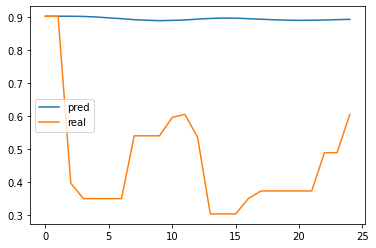

In [40]:
import matplotlib.pyplot as plt

out = []
for j in range(X_test.shape[0]-Ts):
    out.append(me.predict(X_test[j:j+Ts],y_test[j:j+Ts]))

plt.plot(np.array(out)[:,0],label = 'pred')
plt.plot(np.array(out)[:,1],label = 'real')
plt.legend()